# EE 25614: Neuroscience of Learning, Memory, & Cognition
## Fall 2018
## PyTorch Tutorial Assignment
### Deadline: November 2, 2018

### Name: Amirhossein Afsharrad
### Student ID: 95101077


In this assignment, you are tasked with implementing and training a simple recurrent neural network model using PyTorch. You will use this network to solve two tasks.



These are the steps you should take to complete this assignment:
1. Implement VanillaRNN class.
2. Train the network with the datasets you have generated. Visualize how loss changes through epochs.
4. Retrain the data using different sets of parameters. Report and visualize how changing each parameter changes loss. These parameters include:
    - Learning rate
    - Hidden layer size
    - Batch size
    - Number of Epochs
5. Report the parameters of your best network. Run the network on test data and visualize some examples of denoised signals the network makes.
6. Visualize activity of specific neurons through time as they process data in the parity task. Set hidden layer size to a small number for better visuals.

After completing the assignment, upload this notebook in a zip file with your student ID as its name on the CW website.

You should write all of the codes by yourself. Copying codes that are available on the internet or your classmates have written is prohibited.

If you have any questions about this assignment, please ask them on Piazza.

# Part 0: Generating datasets for two tasks.
You should write code that generates training and test datasets for each of the tasks below.


## Task 1: Predicting parity bit of a bit vector
We first define a function to create the parity-bit dataset

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

def parity_generator(N,L):
    X = np.random.randint(0,2,(N,L))
    Y = np.zeros((N,L))
    for i in range (L):
        Y[:,i] = np.sum(X[:,0:i+1],1)%2
    X = torch.from_numpy(X).float()
    Y = torch.from_numpy(Y).double()
    return X, Y

# testing the generator
N = 1000
L = 10
X, Y = parity_generator(N,L)
print(X[0,:])
print(Y[0,:])


tensor([0., 1., 0., 0., 1., 1., 1., 0., 1., 0.])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1.], dtype=torch.float64)


## Task 2: Predicting a denoised sine wave from a noisy signal

"sine_generator" function is defined to create noisy and denoised sine wave dataset with random amplitude and zero phase.


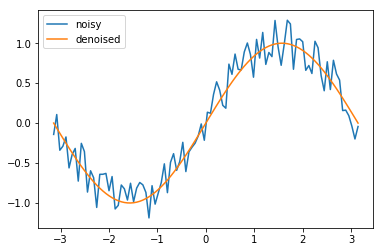

In [5]:
import matplotlib.pylab as plt


def sine_generator(N,L):
    X = np.zeros((N,L))
    Y = np.zeros((N,L))
    x = np.linspace(-np.pi, np.pi, L)
    amplitude = np.random.randn(N,1) * np.ones((N,L))
    amplitude = np.ones((N,L))
    amplitude = np.ones((N,L))*np.random.randint(1, 4, size=(N,1))
    #Y = 10*np.sin(x)*amplitude
    Y = np.sin(x)*amplitude
    X = Y + np.random.uniform(-0.3, 0.3, size=Y.shape)


    return X, Y


# testing the generator
x = np.linspace(-np.pi, np.pi, L)
N = 1000
L=100
X, Y = sine_generator(N,L)

plt.plot(x,np.array(X[120,:]), label = 'noisy')
plt.plot(x,np.array(Y[120,:]), label = 'denoised')
plt.legend()
plt.show()


# Part 1: Vanilla RNN

Equations of a forward pass in a simple RNN network looks like this:

$s_{t}=f(Ux_{t}+b_{U}+Ws_{t-1}+b_{W})$

$o_{t}=f'(Vs_{t}+b_{V})$

Where:

$s_{t}$: Hidden state of RNN at time step t.

$x_{t}$: Input at time step t.

$U$: Learnable weight matrix for connections between the hidden state and input.

$W$: Learnable weight matrix for connections between the hidden states.

$V$: Learnable weight matrix for connections between the hidden state and output.

$o_{t}$: Output at time step t.

$f$ and $f'$: Nonlineartiy functions such as tanh, ReLU, & Softmax

$b_{U}$, $b_{W}$, and $b_{V}$: Bias terms

We talked what the bias term does in the class. In practice, bias terms are not held separately. Using the bias trick, we can store $W$ and bias term of a linear model $y=Wx+b$ in a single matrix. 
![The bias trick](../media/wb.jpg)
Using the bias trick, the equations of RNN are reduce to the following:

$s_{t}=f(Ux_{t}+Ws_{t-1})$

$o_{t}=f'(Vs_{t})$

PyTorch's $nn$ module has a function for a linear models such as $y=Wx+b$. Set $f$ and $f'$ to to *tanh*.

### Vanilla RNN implementation
The following class, called RNN is created as an implementation of Vanilla RNN

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input2hidden = nn.Linear(input_size, hidden_size)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden2output = nn.Linear(hidden_size, output_size)
        self.NonlinearFunc = nn.Tanh()
    
    def forward(self, input, hidden):
        hidden = self.input2hidden(input) + self.hidden2hidden(hidden)
        output = self.NonlinearFunc(self.hidden2output(hidden))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
    
#params = list(rnn.parameters())
#print(len(params))
#print(params[0].size())


### another implementation
The following code is a similar implementation (which won't be used in the tasks) with a little help from https://nipunbatra.github.io/blog/2018/denoising.html

In [44]:
input_dim = 1
hidden_size = 30
num_layers = 1

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        
        self.hidden2output = nn.Linear(hidden_size, output_size, )
        
        self.NonlinearFunc = nn.Tanh()
        
        
    def forward(self, x):
        output, hidden = self.rnn(x, None)
        
        output = self.NonlinearFunc(self.hidden2output(output)).view(output.data.shape[0], -1, 1)
        
        return output

r= RNN2(input_dim, hidden_size, 1)

### parity-bit RNN
the follownig function is defined to train an RNN and show the results for parity bit detection with the following parameters to be adjusted:
1. learning rate
2. hidden layer size
3. batch size
4. number of epochs
5. sequence length (optional)
6. and dataset size (optional)

In [29]:
def predictor(output):
    return (output>0.5).double()    

def parity (learning_rate, hidden_size, batch_size, number_of_epochs, sequence_length=10, dataset_size = 100):

    rnn = RNN(input_size=1, hidden_size=hidden_size, output_size=1)
    
    L = sequence_length
    
    N = dataset_size
    
    num_of_batches = int(N/batch_size)
    
    input, target = parity_generator(N,L)
    
    epochs_samples = np.zeros(int(number_of_epochs/20))
    
    epoch_loss = np.zeros(int(number_of_epochs/20))


    for epochs in range(number_of_epochs):
        criterion = nn.MSELoss()

        learning_rate = 0.005

        optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
      #  optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

        OUT = torch.tensor(np.zeros((batch_size, L)))

        rnn.zero_grad()

        for k in range (num_of_batches):
            for i in range (batch_size):
                hidden = rnn.init_hidden()
                for j in range (L):
                    output, hidden = rnn(input[k*batch_size+i,j].unsqueeze(0), hidden)
                    OUT[i,j] = output
                    #loss += criterion(output.double(), target[k*batch_size+i,j].unsqueeze(0).unsqueeze(0))
        loss = criterion(OUT.double(), target[k*batch_size:(k+1)*batch_size,:])
        loss.backward()
        optimizer.step()
        
        
        if (epochs%20==0):
            print('epoch=',epochs, ', loss=', loss.item())
            number = int(epochs/20)
            epochs_samples[number] = epochs
            epoch_loss[number] = loss.item()

    predictedOUT = predictor(OUT[-1,:])
    plt.figure
    plt.subplot(2,1,1)
    plt.plot(OUT.detach().numpy()[-1,:],label='out')
    plt.plot(predictedOUT.numpy().squeeze(),label='predicted_out')
    plt.plot(input.detach().numpy()[-1,:],label='in')
    plt.plot(target.detach().numpy()[-1,:],label='target')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(epochs_samples, epoch_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
    hidden = rnn.init_hidden()
    O = torch.tensor(np.zeros(L))
    Hidden = torch.tensor(np.zeros((L,hidden_size,10)))
    for test in range (10):
        hidden = rnn.init_hidden()
        for i in range (L):
            rnn.zero_grad()
            output, hidden = rnn(input[N-10+test,i].unsqueeze(0), hidden)
            Hidden[i,:,test] = hidden
            O[i] = output

    plt.figure
    plt.imshow(np.array(input[N-10:N,:]).T)
    plt.title('input')
    plt.show()

    for unit in range(hidden_size):
        Hid = np.array(Hidden[:,unit,:].detach().numpy())
        plt.figure
        plt.imshow(Hid.T)
        plt.title('neural activity')
        plt.show()

    OUTPUT = predictor(O)
    E = abs(OUTPUT-target[N-1,:])
    print('percentage=',(100-100*torch.sum(E)/(L)).item())

        
    return


Now we shall test the network with different parameters
### Learning Rate

epoch= 0 , loss= 0.26717586333920007
epoch= 20 , loss= 0.2660321706852899
epoch= 40 , loss= 0.26500404428993385
epoch= 60 , loss= 0.26407476569163135
epoch= 80 , loss= 0.26323081794375225
tensor([0., 1., 1., 1., 0., 0., 0., 1., 1., 1.], dtype=torch.float64)


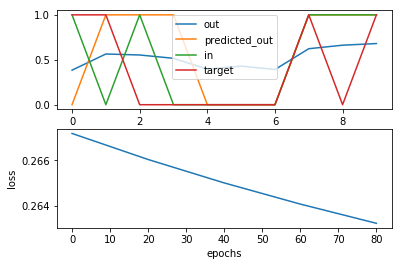

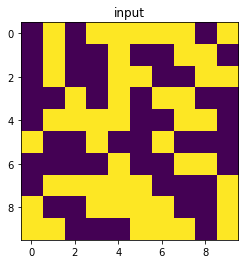

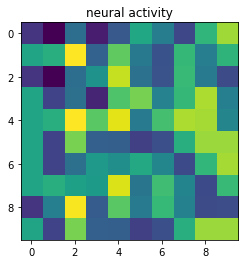

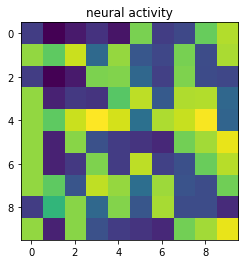

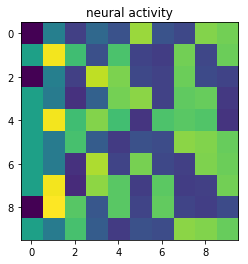

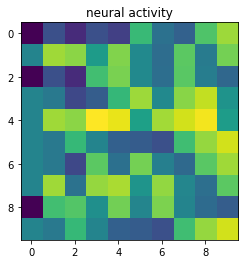

percentage= 60.0


In [28]:
parity (learning_rate=0.001, hidden_size=4, batch_size=50, number_of_epochs=100, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 1.3971918034613833
epoch= 20 , loss= 0.9224888115977147
epoch= 40 , loss= 0.6005883739735565
epoch= 60 , loss= 0.43372721755490723
epoch= 80 , loss= 0.35204196299874324
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


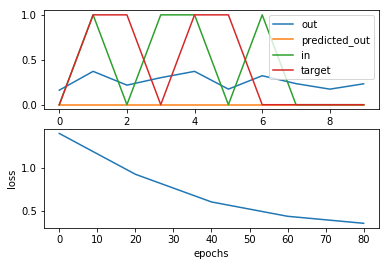

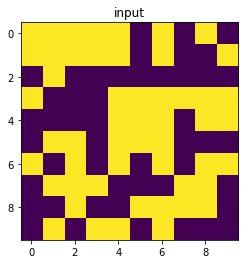

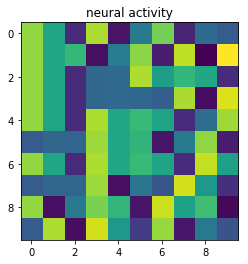

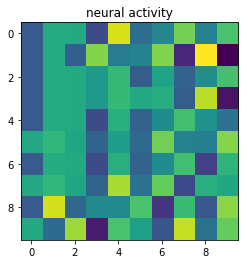

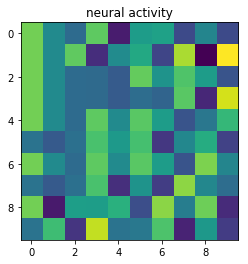

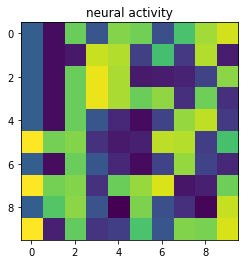

percentage= 60.0


In [22]:
parity (learning_rate=0.005, hidden_size=4, batch_size=50, number_of_epochs=100, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 0.39688244246806215
epoch= 20 , loss= 0.2798382327231395
epoch= 40 , loss= 0.25710243397991256
epoch= 60 , loss= 0.25174347776320877
epoch= 80 , loss= 0.25026357378962555
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 1.], dtype=torch.float64)


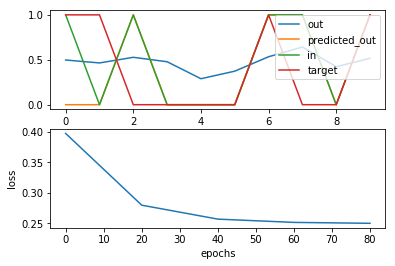

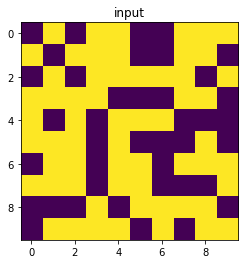

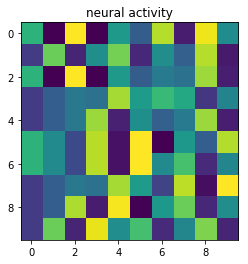

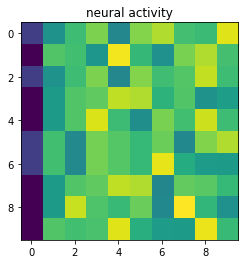

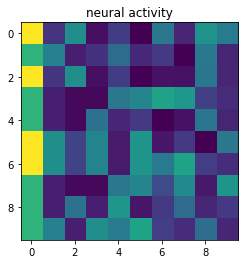

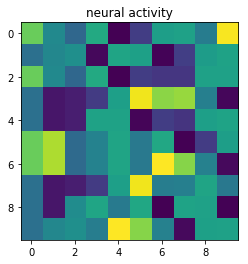

percentage= 60.0


In [23]:
parity (learning_rate=0.02, hidden_size=4, batch_size=50, number_of_epochs=100, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 0.3766408103081652
epoch= 20 , loss= 0.31648488750465026
epoch= 40 , loss= 0.2734645965613848
epoch= 60 , loss= 0.2580950639856818
epoch= 80 , loss= 0.25443341746380216
tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 0.], dtype=torch.float64)


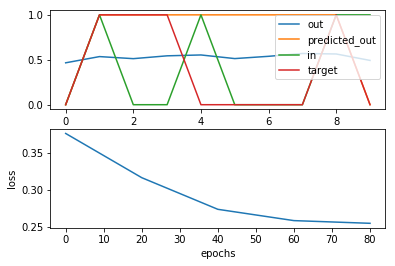

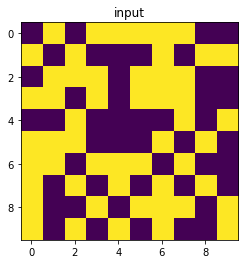

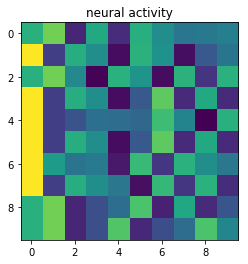

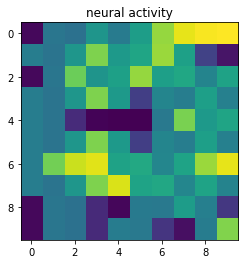

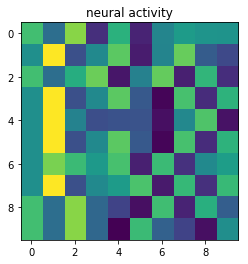

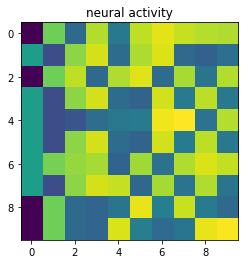

percentage= 60.0


In [25]:
parity (learning_rate=0.5, hidden_size=4, batch_size=50, number_of_epochs=100, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 0.2980435597638195
epoch= 20 , loss= 0.27274087983285006
epoch= 40 , loss= 0.26357775351212276
epoch= 60 , loss= 0.25966495953405366
epoch= 80 , loss= 0.2576599341165836


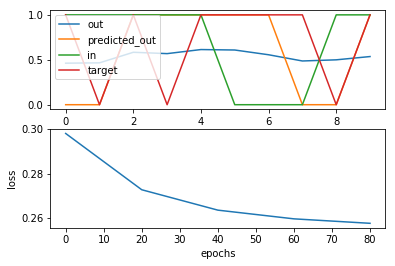

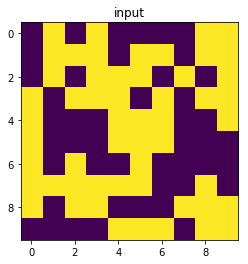

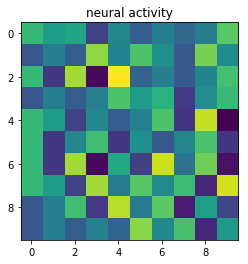

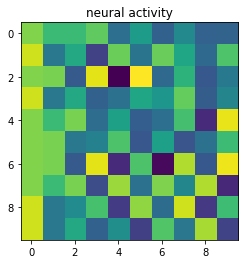

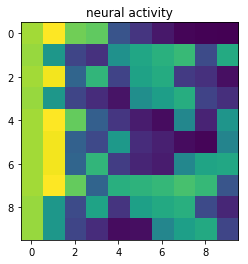

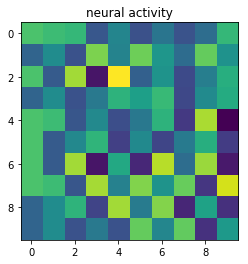

percentage= 60.0


In [30]:
parity (learning_rate=5, hidden_size=4, batch_size=50, number_of_epochs=100, sequence_length=10, dataset_size = 100)

CONCLUSION:
Higher learning rates gave faster loss decrease rate. We know that high learning rates can cause problems like not converging to the best value but in the examples tested until now, this was not observes.

### Hidden Layer Size
Now we shall test different amounts of hidden layer size

epoch= 0 , loss= 1.3205670985030273
epoch= 20 , loss= 1.0252447000548082
epoch= 40 , loss= 0.7362910002947196
epoch= 60 , loss= 0.518978536834913
epoch= 80 , loss= 0.38881028079232854
epoch= 100 , loss= 0.31993393505082884
epoch= 120 , loss= 0.2847526196949886
epoch= 140 , loss= 0.26660911068841375
epoch= 160 , loss= 0.2570170612720947
epoch= 180 , loss= 0.2518079383456222


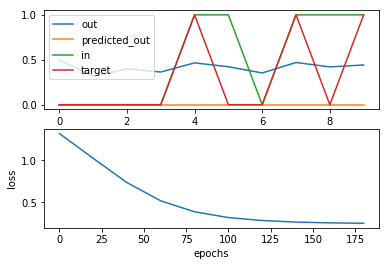

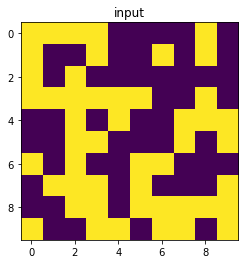

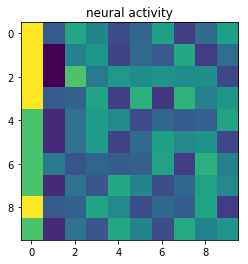

percentage= 70.0


In [34]:
parity (learning_rate=0.05, hidden_size=1, batch_size=50, number_of_epochs=200, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 0.2771485001243688
epoch= 20 , loss= 0.27222534079121546
epoch= 40 , loss= 0.26921106269111394
epoch= 60 , loss= 0.2668643294783105
epoch= 80 , loss= 0.2648684615470168
epoch= 100 , loss= 0.263124929631513
epoch= 120 , loss= 0.2615866153910033
epoch= 140 , loss= 0.2602216525976922
epoch= 160 , loss= 0.2590050785127465
epoch= 180 , loss= 0.25791641785185476


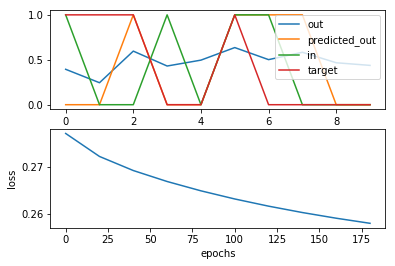

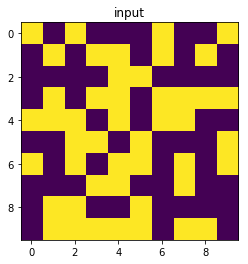

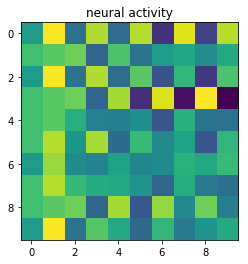

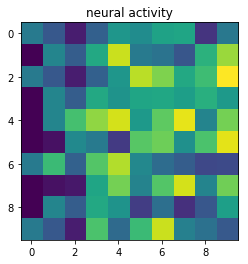

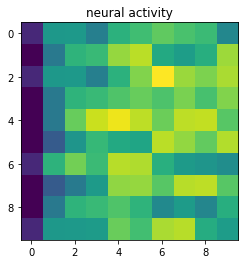

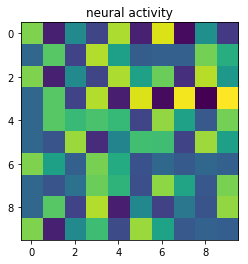

percentage= 60.0


In [35]:
parity (learning_rate=0.05, hidden_size=4, batch_size=50, number_of_epochs=200, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 0.5588529020346129
epoch= 20 , loss= 0.29158427035434953
epoch= 40 , loss= 0.27322530791163696
epoch= 60 , loss= 0.26872594293362545
epoch= 80 , loss= 0.2656351972428748
epoch= 100 , loss= 0.2629416117924865
epoch= 120 , loss= 0.2605555764181847
epoch= 140 , loss= 0.25846699202453
epoch= 160 , loss= 0.25666255613388067
epoch= 180 , loss= 0.25512042258059625


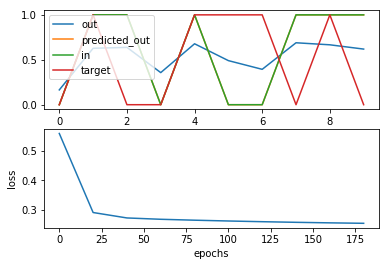

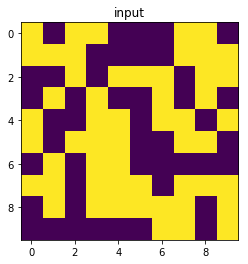

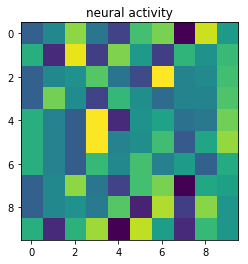

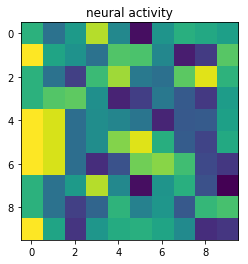

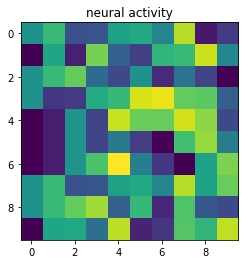

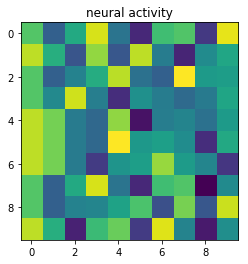

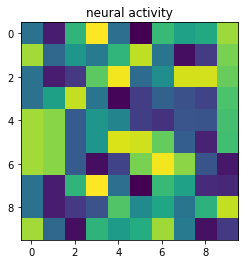

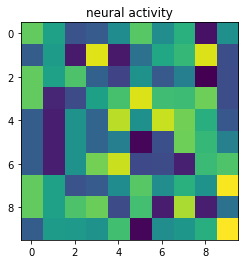

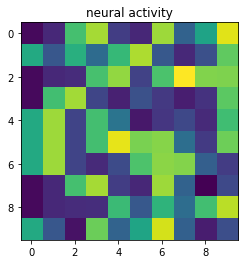

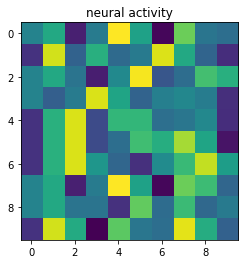

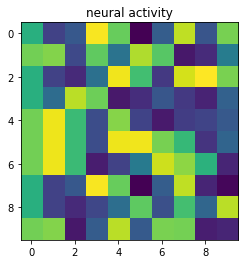

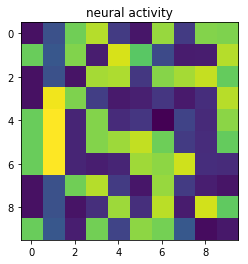

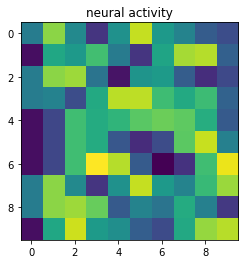

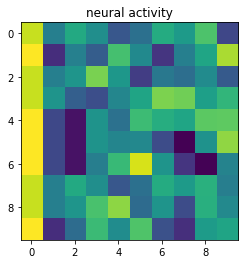

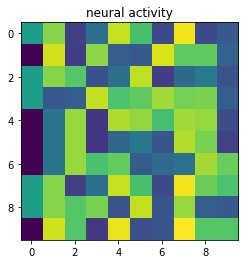

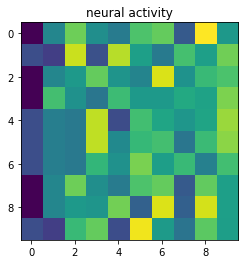

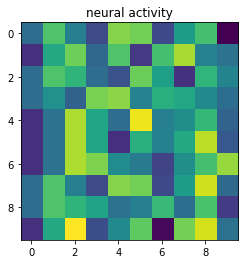

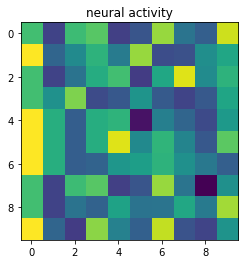

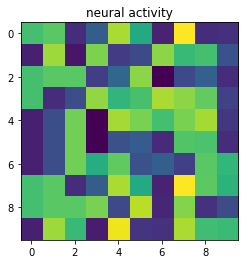

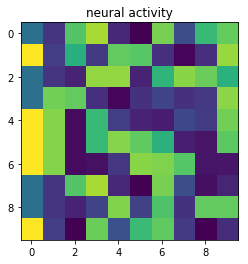

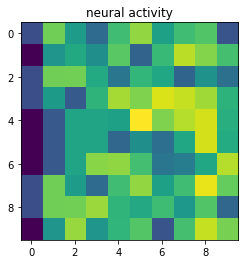

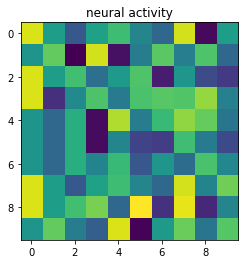

percentage= 50.0


In [36]:
parity (learning_rate=0.05, hidden_size=20, batch_size=50, number_of_epochs=200, sequence_length=10, dataset_size = 100)

CONCLUSION:
adding too many hidden layers will not be good and the final percentage is less than the previous experiments.

### Batch Size
Now we shall test different batch sizes

epoch= 0 , loss= 0.9316090862728876
epoch= 20 , loss= 0.30669429861089775
epoch= 40 , loss= 0.24334878886355327
epoch= 60 , loss= 0.2251373607142722
epoch= 80 , loss= 0.21586749831790905
epoch= 100 , loss= 0.20980457798000424
epoch= 120 , loss= 0.20529143869546687
epoch= 140 , loss= 0.20166727142417712
epoch= 160 , loss= 0.1986127016169963
epoch= 180 , loss= 0.19595271332917932


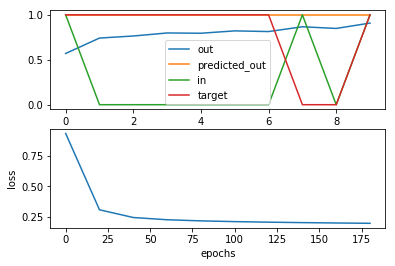

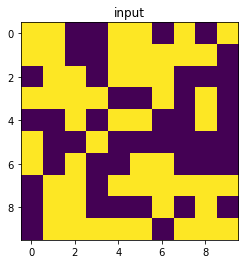

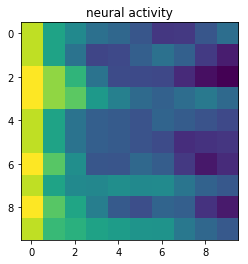

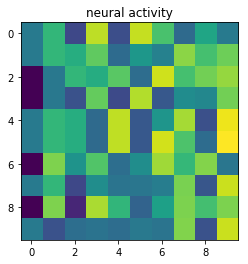

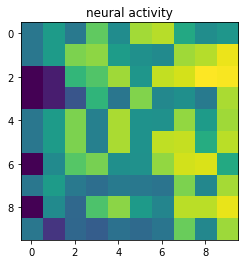

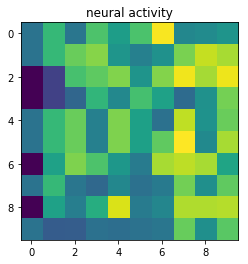

percentage= 80.0


In [37]:
parity (learning_rate=0.05, hidden_size=4, batch_size=1, number_of_epochs=200, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 0.539827888175347
epoch= 20 , loss= 0.35337347868624575
epoch= 40 , loss= 0.30580607410888805
epoch= 60 , loss= 0.2814536455867482
epoch= 80 , loss= 0.2682921796433911
epoch= 100 , loss= 0.26067062204315494
epoch= 120 , loss= 0.2559295413431263
epoch= 140 , loss= 0.2527751349535835
epoch= 160 , loss= 0.2505474340578467
epoch= 180 , loss= 0.24889186712639702


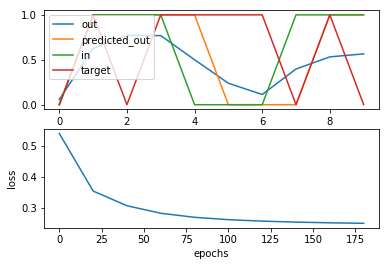

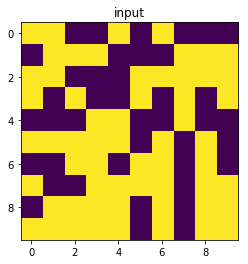

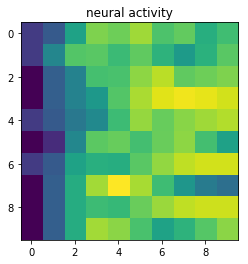

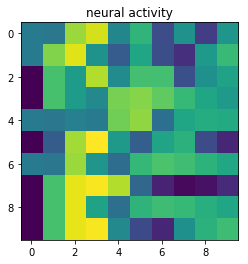

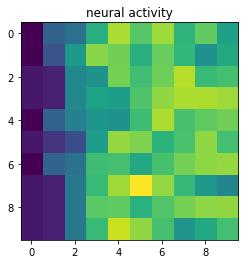

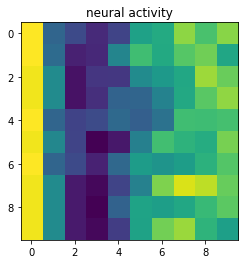

percentage= 60.0


In [38]:
parity (learning_rate=0.05, hidden_size=4, batch_size=10, number_of_epochs=200, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 0.4316207194560624
epoch= 20 , loss= 0.32023885167672433
epoch= 40 , loss= 0.29800759753833733
epoch= 60 , loss= 0.2912244890805902
epoch= 80 , loss= 0.28785464238675157
epoch= 100 , loss= 0.28542696295109815
epoch= 120 , loss= 0.2833408353554034
epoch= 140 , loss= 0.28143210158347365
epoch= 160 , loss= 0.2796500976943498
epoch= 180 , loss= 0.2779756499505831


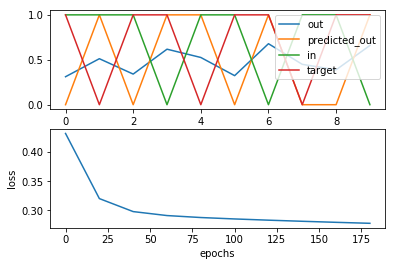

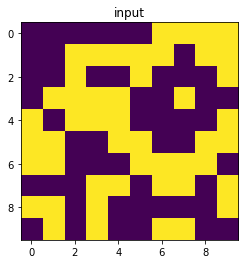

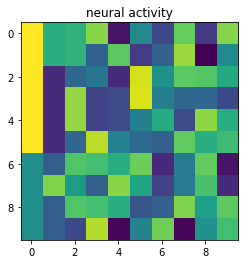

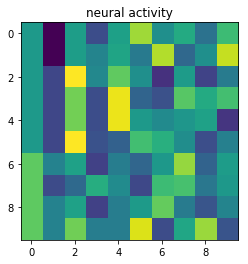

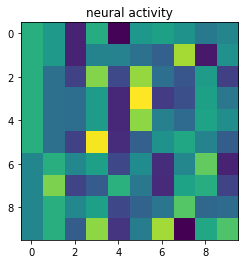

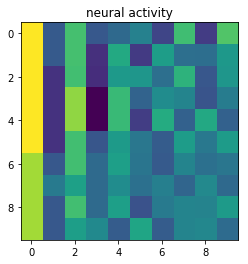

percentage= 40.0


In [39]:
parity (learning_rate=0.05, hidden_size=4, batch_size=50, number_of_epochs=200, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 1.0308259003007672
epoch= 20 , loss= 0.3409024424710887
epoch= 40 , loss= 0.3147259663103015
epoch= 60 , loss= 0.3072923439342739
epoch= 80 , loss= 0.3014251932819143
epoch= 100 , loss= 0.29634604806692394
epoch= 120 , loss= 0.2918934456376361
epoch= 140 , loss= 0.28796464943556105
epoch= 160 , loss= 0.28447892379183154
epoch= 180 , loss= 0.2813709090412827


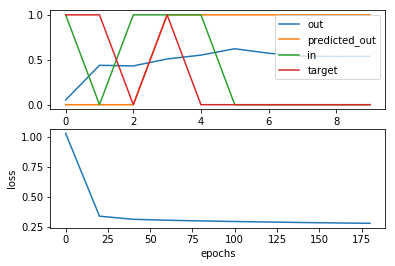

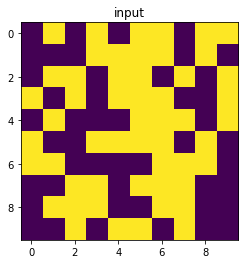

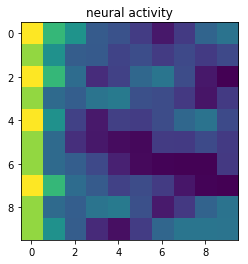

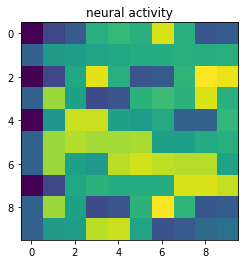

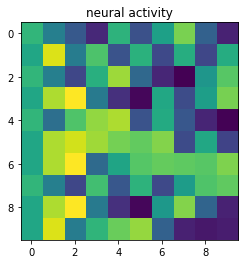

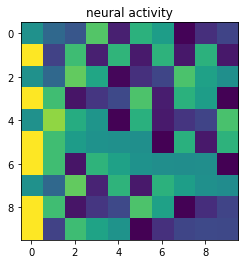

percentage= 20.0


In [41]:
parity (learning_rate=0.05, hidden_size=4, batch_size=100, number_of_epochs=200, sequence_length=10, dataset_size = 100)

CONCLUSION:
looks like too much increasing the batch size results in bad functionality, a low percentage and lower rate at which the loss decreases. Also we know that a very small learning rate might result in a lot of noise (which was not observed here) so we shall choose a batch size neither too small nor too large.
### Number of Epochs:
Now we shall test the different numbers of epochs

epoch= 0 , loss= 1.5992090794530243
epoch= 20 , loss= 0.5247275390896603


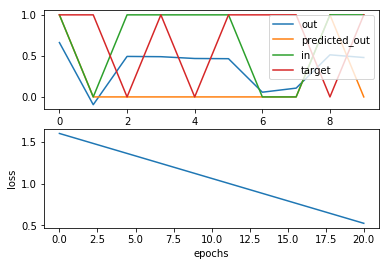

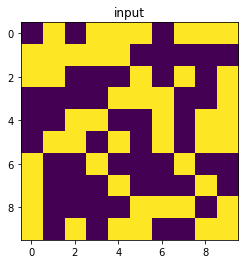

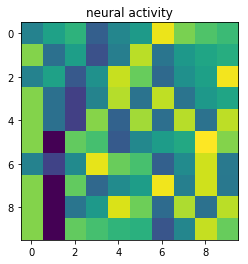

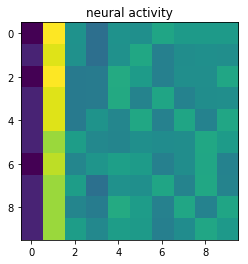

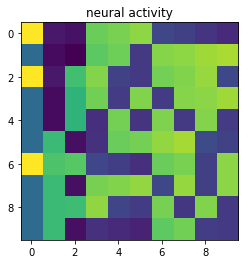

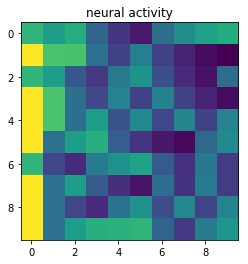

percentage= 30.0


In [43]:
parity (learning_rate=0.05, hidden_size=4, batch_size=20, number_of_epochs=40, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 1.263636473795835
epoch= 20 , loss= 0.34295521340064905
epoch= 40 , loss= 0.28980055866253507
epoch= 60 , loss= 0.28193933832928486
epoch= 80 , loss= 0.27637561781223596


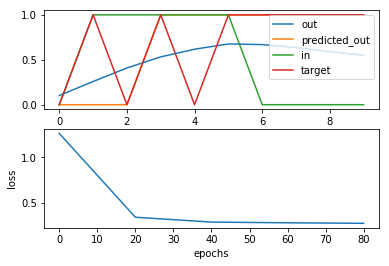

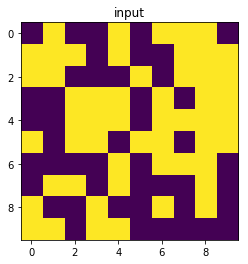

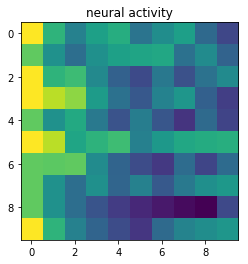

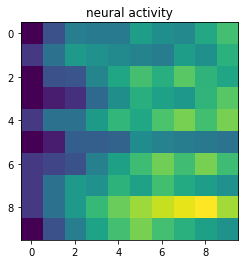

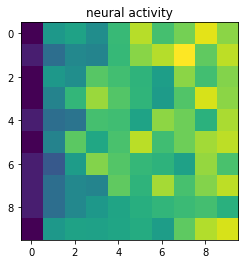

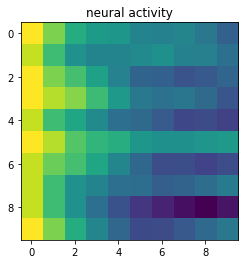

percentage= 80.0


In [44]:
parity (learning_rate=0.05, hidden_size=4, batch_size=50, number_of_epochs=100, sequence_length=10, dataset_size = 100)

epoch= 0 , loss= 0.4461139443965265
epoch= 20 , loss= 0.27331399569942394
epoch= 40 , loss= 0.26381327768957086
epoch= 60 , loss= 0.26230900628397297
epoch= 80 , loss= 0.2614407210717232
epoch= 100 , loss= 0.2606867901024585
epoch= 120 , loss= 0.2599956740988158
epoch= 140 , loss= 0.2593558564045059
epoch= 160 , loss= 0.25876057513349
epoch= 180 , loss= 0.2582044557811849
epoch= 200 , loss= 0.2576830138485721
epoch= 220 , loss= 0.2571924928562434
epoch= 240 , loss= 0.2567296707798708
epoch= 260 , loss= 0.25629182098003417
epoch= 280 , loss= 0.2558766038320941


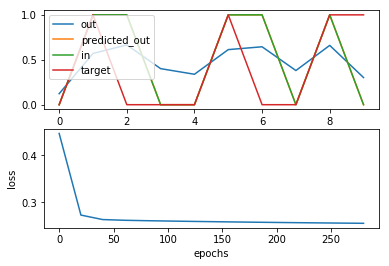

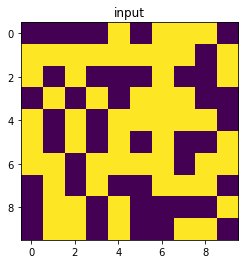

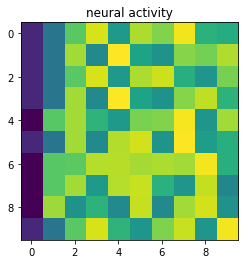

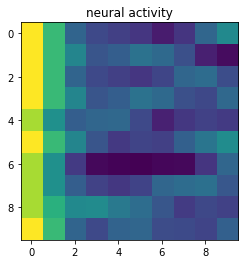

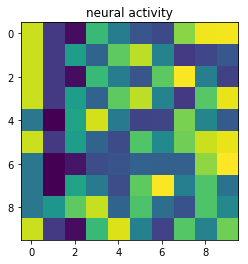

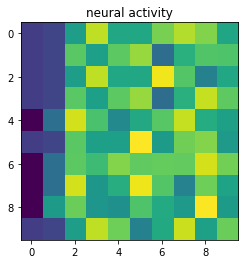

percentage= 70.0


In [45]:
parity (learning_rate=0.05, hidden_size=4, batch_size=50, number_of_epochs=300, sequence_length=10, dataset_size = 100)

CONCLUSION:
increasing the number of epochs will result in smaller values of loss but too many ot them causes overfitting and makes the final percentage decrease.

the last RNN is a sample of the good-working RNN
note that unfotunately the implemented RNN does not work as good as expected but I have done whatever I could!

## Denoising Problem
the following function trains and tests an RNN for denoising a sine wave with the following parameters to be adjusted:
1. learning rate
2. hidden layer size
3. batch size
4. number of epochs
5. sequence length (optional)
6. and dataset size (optional)

In [48]:
def denoising (learning_rate, hidden_size, batch_size, number_of_epochs, number_of_time_samples=20, dataset_size = 100):

    rnn = RNN(input_size=1, hidden_size=hidden_size, output_size=1)

    L = number_of_time_samples
    N = dataset_size

    num_of_batches = int(N/batch_size)

    input, target = sine_generator(N,L)
    input = torch.tensor(input)
    target = torch.tensor(target)
    
    epochs_samples = np.zeros(int(number_of_epochs/20))
    
    epoch_loss = np.zeros(int(number_of_epochs/20))

    for epochs in range(number_of_epochs):
        criterion = nn.MSELoss()

        optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
      #  optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

        OUT = torch.tensor(np.zeros((batch_size, L)))

        rnn.zero_grad()

        for k in range (num_of_batches):
            for i in range (batch_size):
                hidden = rnn.init_hidden()
                for j in range (L):
                    output, hidden = rnn(input[k*batch_size+i,j].float().unsqueeze(0), hidden.float())
                    OUT[i,j] = output
                    #loss += criterion(output.double(), target[k*batch_size+i,j].unsqueeze(0).unsqueeze(0))
        loss = criterion(OUT.double(), target[k*batch_size:(k+1)*batch_size,:])
        loss.backward()
        optimizer.step()

        if (epochs%20==0):
            print('epoch=',epochs, ', loss=', loss.item())
            number = int(epochs/20)
            epochs_samples[number] = epochs
            epoch_loss[number] = loss.item()


    plt.figure
    plt.subplot(2,1,1)
    plt.plot(OUT.detach().numpy()[-1,:],label='out')
    plt.plot(input.detach().numpy()[-1,:],label='in')
    plt.plot(target.detach().numpy()[-1,:],label='target')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(epochs_samples, epoch_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
    return



We shall test different parameters:
### Learning Rate:
First we test different learning rates

epoch= 0 , loss= 2.273350689571264
epoch= 20 , loss= 1.1536367671178527
epoch= 40 , loss= 1.0173041924754413
epoch= 60 , loss= 0.9554797405017568
epoch= 80 , loss= 0.9156136817931124


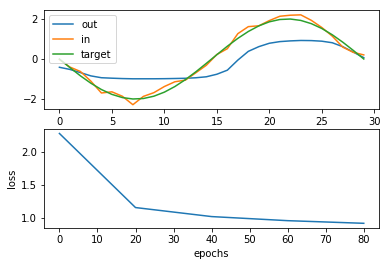

In [47]:
denoising(learning_rate = 0.001, hidden_size = 4, batch_size = 50, number_of_epochs = 100)

epoch= 0 , loss= 3.274884799047941
epoch= 20 , loss= 0.8427410528686459
epoch= 40 , loss= 0.7998653226208224
epoch= 60 , loss= 0.7835861175658647
epoch= 80 , loss= 0.7738233889741393


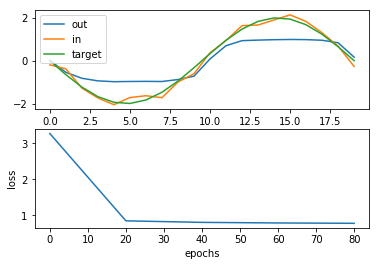

In [49]:
denoising(learning_rate = 0.01, hidden_size = 4, batch_size = 50, number_of_epochs = 100)

epoch= 0 , loss= 3.1430998884697514
epoch= 20 , loss= 0.6532767235295969
epoch= 40 , loss= 0.6491770506071574
epoch= 60 , loss= 0.6482688583994456
epoch= 80 , loss= 0.6478396216328112


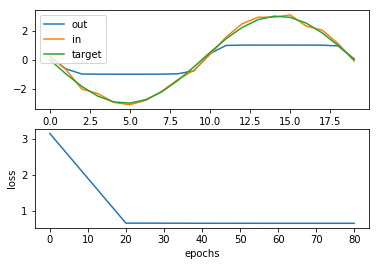

In [50]:
denoising(learning_rate = 0.1, hidden_size = 4, batch_size = 50, number_of_epochs = 100)

epoch= 0 , loss= 2.329084863823133
epoch= 20 , loss= 3.213482408913522
epoch= 40 , loss= 3.2134998238162233
epoch= 60 , loss= 3.213499773634051
epoch= 80 , loss= 3.213499682927792


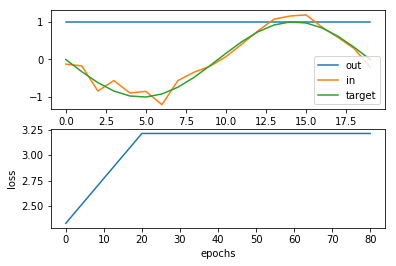

In [51]:
denoising(learning_rate = 5, hidden_size = 4, batch_size = 50, number_of_epochs = 100)

CONCLUSION:
The result is that with a very low learning rate, the process of convergence is too slow but when you increase the learning rate too much, there might be no convergence. This is the very interesting result of the last test (lr = 5) which we can see that the loss increases and never decreases again, which is because of the too big step-size of the learning rate.

### Hidden Layer Size
Now we shall test different values of hidden layer size

epoch= 0 , loss= 3.08873641167256
epoch= 20 , loss= 0.7898721530957862
epoch= 40 , loss= 0.7878280079722982
epoch= 60 , loss= 0.7873511500060747
epoch= 80 , loss= 0.7871478944514779


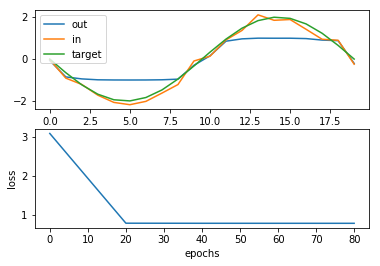

In [52]:
denoising(learning_rate = 0.1, hidden_size = 1, batch_size = 50, number_of_epochs = 100)

epoch= 0 , loss= 1.2232260015208167
epoch= 20 , loss= 0.5142479521319069
epoch= 40 , loss= 0.5074537015074263
epoch= 60 , loss= 0.5060231068337121
epoch= 80 , loss= 0.5053490422638427


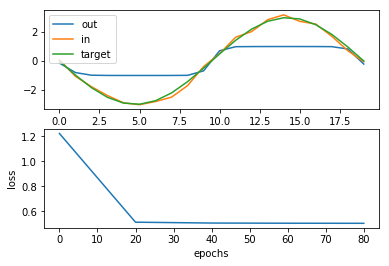

In [55]:
denoising(learning_rate = 0.1, hidden_size = 4, batch_size = 50, number_of_epochs = 100)

epoch= 0 , loss= 1.5468839324939683
epoch= 20 , loss= 0.5775254031847497
epoch= 40 , loss= 0.5675533359971068
epoch= 60 , loss= 0.5650603751069081
epoch= 80 , loss= 0.5643220811706675


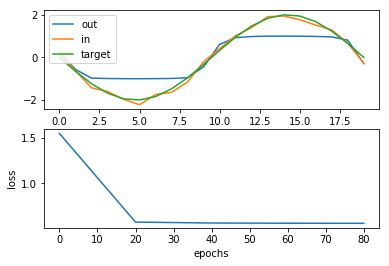

In [54]:
denoising(learning_rate = 0.1, hidden_size = 20, batch_size = 50, number_of_epochs = 100)

epoch= 0 , loss= 0.6995809895798709
epoch= 20 , loss= 0.6387769350413329
epoch= 40 , loss= 0.638700627426947
epoch= 60 , loss= 0.6376023056248522
epoch= 80 , loss= 0.6373967686438221


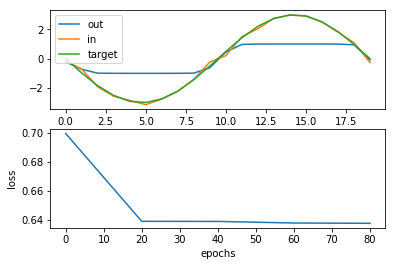

In [56]:
denoising(learning_rate = 0.1, hidden_size = 100, batch_size = 50, number_of_epochs = 100)

CONCLUSION:
Too much increasing the hidden layer size does not make the performance any better and also might cause additional loss and worse result as observed
### Batch Size:
Now we shall test different values of batch size

epoch= 0 , loss= 7.3230903859744085
epoch= 20 , loss= 1.5462632839501023
epoch= 40 , loss= 1.5417270576152649
epoch= 60 , loss= 1.5404693792273065
epoch= 80 , loss= 1.5396573980896473


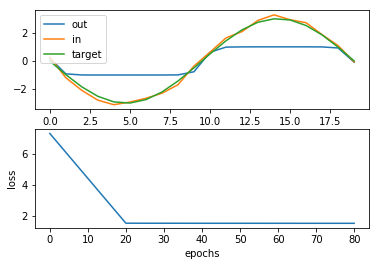

In [57]:
denoising(learning_rate = 0.1, hidden_size = 4, batch_size = 1, number_of_epochs = 100)

epoch= 0 , loss= 1.4208442649630448
epoch= 20 , loss= 0.6730882962386586
epoch= 40 , loss= 0.6696086647596293
epoch= 60 , loss= 0.667506342189693
epoch= 80 , loss= 0.6661036969927436


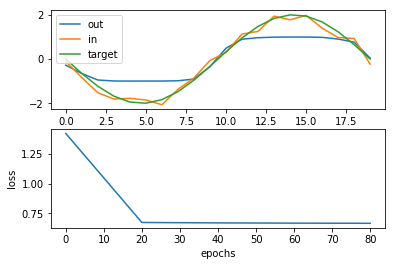

In [58]:
denoising(learning_rate = 0.1, hidden_size = 4, batch_size = 10, number_of_epochs = 100)

epoch= 0 , loss= 4.711671835800693
epoch= 20 , loss= 0.9091556706243659
epoch= 40 , loss= 0.9059492147536153
epoch= 60 , loss= 0.9036784202774639
epoch= 80 , loss= 0.9006067521314151


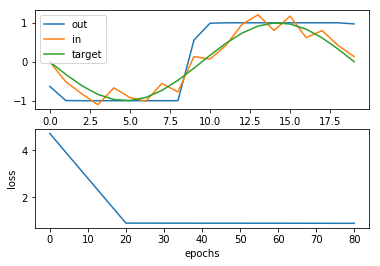

In [59]:
denoising(learning_rate = 0.1, hidden_size = 100, batch_size = 50, number_of_epochs = 100)

epoch= 0 , loss= 4.0828323050214035
epoch= 20 , loss= 0.7735386825011417
epoch= 40 , loss= 0.7674990679401079
epoch= 60 , loss= 0.7621468340709874
epoch= 80 , loss= 0.7549186552597953


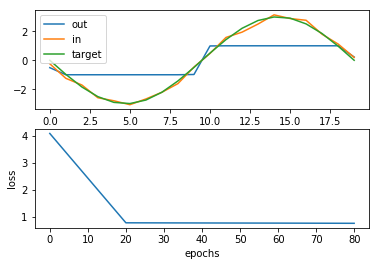

In [60]:
denoising(learning_rate = 0.1, hidden_size = 100, batch_size = 100, number_of_epochs = 100)

CONCLUSION:
According to the results, batch size is the best when not to small and not too large. Small batch sizes result in noise and very large ones may cause a lowrt speed of convergence (as observed above) but a moderate value might be the best.
### Number of epochs:
Now we shall test different values of batch size

epoch= 0 , loss= 1.6713786556093968
epoch= 20 , loss= 0.663109329739979


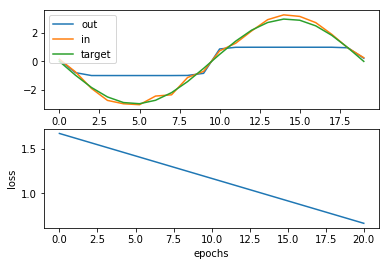

In [71]:
denoising(learning_rate = 0.1, hidden_size = 20, batch_size = 20, number_of_epochs = 40)

epoch= 0 , loss= 3.291768457290698
epoch= 20 , loss= 0.48329945838628524
epoch= 40 , loss= 0.4825040720660019
epoch= 60 , loss= 0.48206613666702075
epoch= 80 , loss= 0.48172725352350715


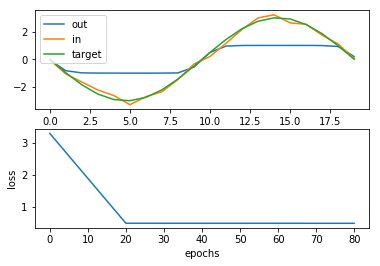

In [66]:
denoising(learning_rate = 0.1, hidden_size = 20, batch_size = 20, number_of_epochs = 100)

epoch= 0 , loss= 2.802679053970781
epoch= 20 , loss= 0.665886211157465
epoch= 40 , loss= 0.6517832250685928
epoch= 60 , loss= 0.6380160723389775
epoch= 80 , loss= 0.6306040327329651
epoch= 100 , loss= 0.6279728140032967
epoch= 120 , loss= 0.626478949869819
epoch= 140 , loss= 0.6254363393957681
epoch= 160 , loss= 0.6247074857508873
epoch= 180 , loss= 0.62420608004655
epoch= 200 , loss= 0.6238656181522336
epoch= 220 , loss= 0.6236352391270167
epoch= 240 , loss= 0.6234776774691467
epoch= 260 , loss= 0.6233669762366812
epoch= 280 , loss= 0.6232858880629001


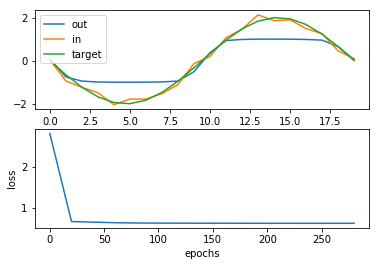

In [67]:
denoising(learning_rate = 0.1, hidden_size = 20, batch_size = 20, number_of_epochs = 300)

epoch= 0 , loss= 1.0425417483104922
epoch= 20 , loss= 0.5430074552641693
epoch= 40 , loss= 0.5309017443179234
epoch= 60 , loss= 0.5262248855968514
epoch= 80 , loss= 0.5236601864397296
epoch= 100 , loss= 0.5220573271805901
epoch= 120 , loss= 0.5209830607072746
epoch= 140 , loss= 0.5202281140070396
epoch= 160 , loss= 0.519677586880374
epoch= 180 , loss= 0.5192633801546581
epoch= 200 , loss= 0.5189429512988548
epoch= 220 , loss= 0.5186886689062657
epoch= 240 , loss= 0.5184820404371779
epoch= 260 , loss= 0.5183103552452561
epoch= 280 , loss= 0.5181647105260576
epoch= 300 , loss= 0.518038741525675
epoch= 320 , loss= 0.5179278386213684
epoch= 340 , loss= 0.5178286139178205
epoch= 360 , loss= 0.5177385473992238
epoch= 380 , loss= 0.517655749993646
epoch= 400 , loss= 0.5175787792664925
epoch= 420 , loss= 0.5175065409149994
epoch= 440 , loss= 0.5174381850804892
epoch= 460 , loss= 0.517373051852115
epoch= 480 , loss= 0.5173106336073091


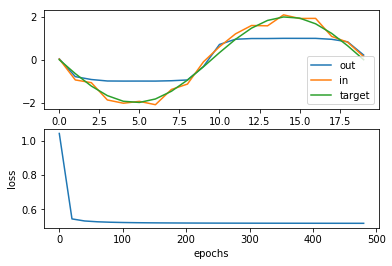

In [69]:
denoising(learning_rate = 0.01, hidden_size = 20, batch_size = 20, number_of_epochs = 500)

CONCLUSION: increasing the number of epochs in general decreases the values of loss but cause overfitting

epoch= 0 , loss= 1.2428781985322828
epoch= 20 , loss= 0.691157326382345


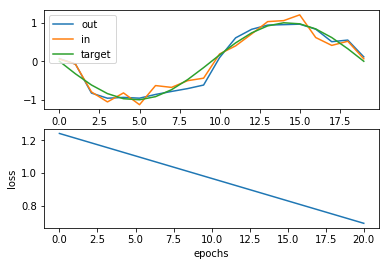

In [70]:
a sample of a quite good working RNN:
denoising(learning_rate = 0.1, hidden_size = 20, batch_size = 20, number_of_epochs = 40)

note that unfotunately the implemented RNN does not work as good as expected but I have done whatever I could!